In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import astropy.units as u
import astropy.constants as const
# %matplotlib inline

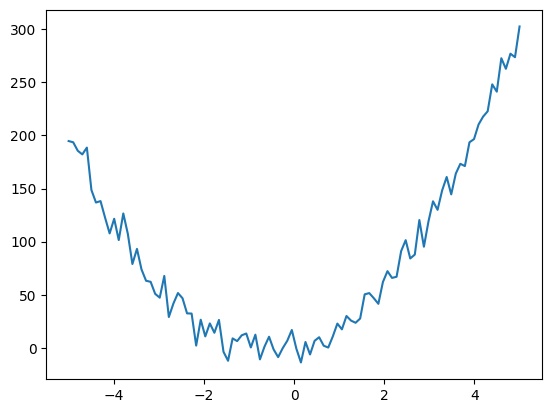

In [2]:
x_train = np.linspace(-5, 5, 100)
def gen_data(t, a, b, c, mu=0, sigma=0):
    y = a*(t**2) + b*t + c
    noise = np.random.normal(mu, sigma, len(t))
    y_train = y + noise
    return y_train
y_train = gen_data(x_train, 10, 10, 0, mu=0, sigma=10)
plt.plot(x_train, y_train)

In [3]:
def fun(x, t, y):
    """
        x[0] = a
        x[1] = b
        x[2] = c
        y = a*(x**2) + b*x + c
    """
    return x[0]*t**2 + x[1]*t + x[2] - y
    

In [4]:
x0 = [-900, 5, 1]
res_lsq = least_squares(fun, x0, args=(x_train, y_train))
res_lsq

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.262e+00 -4.529e+00 ...  1.508e+01 -2.852e+00]
           x: [ 9.960e+00  1.017e+01 -1.798e-01]
        cost: 4904.803406951835
         jac: [[ 2.500e+01 -5.000e+00  1.000e+00]
               [ 2.400e+01 -4.899e+00  1.000e+00]
               ...
               [ 2.400e+01  4.899e+00  1.000e+00]
               [ 2.500e+01  5.000e+00  1.000e+00]]
        grad: [ 1.297e-05 -8.882e-06  2.842e-14]
  optimality: 1.2968594205631234e-05
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 4
        njev: 4

In [5]:
y_lsq = gen_data(x_train, *res_lsq.x)

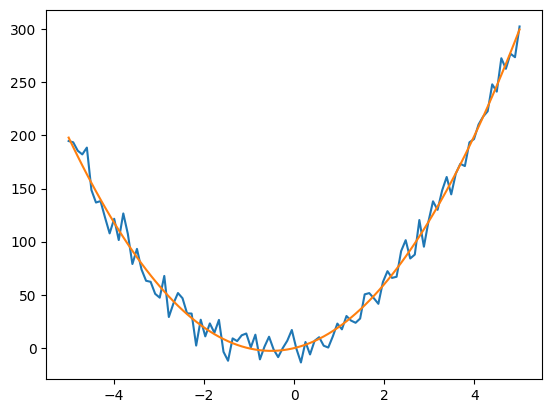

In [6]:
plt.plot(x_train, y_train)
plt.plot(x_train, y_lsq)


In [2]:
from ysopy import base_funcs as bf
dict_config = bf.config_read("config_file.cfg")
dict_config

{'b': <Quantity 1. kG>,
 'm': <Quantity 6.36291159e+30 kg>,
 'm_dot': <Quantity 2.52035626e+16 kg / s>,
 'r_star': <Quantity 1.18269e+09 m>,
 'log_g_star': 3.5,
 'inclination': <Quantity 38. deg>,
 'd_star': <Quantity 3.08567758e+17 m>,
 't_star': <Quantity 4600. K>,
 't_0': <Quantity 4600. K>,
 'av': 10.0,
 'rv': 3.1,
 'l_0': <Quantity 3000. Angstrom>,
 'l_l_slab': <Quantity 3000. Angstrom>,
 'mag_comp': 'hslab',
 't_slab': <Quantity 8500. K>,
 'n_e': <Quantity 1.e+13 1 / cm3>,
 'tau': 1.0,
 'save': True,
 'plot': False,
 'save_grid_data': False,
 'save_each': False,
 'l_min': <Quantity 1250. Angstrom>,
 'l_max': <Quantity 50000. Angstrom>,
 'n_data': 420000,
 'n_disk': 500,
 'n_dust_disk': 2000,
 'n_h_minus': 5000,
 'n_h': 150,
 'bt_settl_path': '/Users/tusharkantidas/NIUS/Temp',
 'save_loc': '/Users/tusharkantidas/NIUS/testing/Contribution/Planetesimal2',
 'h_grid_path': '/Users/tusharkantidas/NIUS/refactoring/grid/h_emission/Sample',
 'h_min_grid_path': '/Users/tusharkantidas/NIUS/

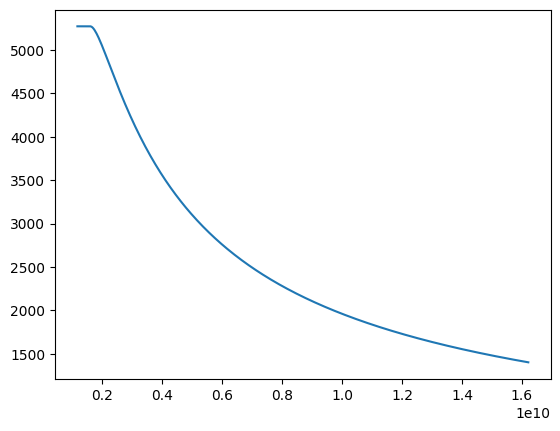

In [3]:
r_train = np.load("radius_arr.npy")
temp_train = np.load("temp_arr.npy")
plt.plot(r_train, temp_train)
plt.show()

In [3]:
print(f" B: {dict_config['b']} \n m: {dict_config['m']} \n m_dot: {dict_config['m_dot']} \n R: {dict_config['r_star']}")

 B: 1.0 kG 
 m: 6.362911586233763e+30 kg 
 m_dot: 2.520356263718471e+16 kg / s 
 R: 1182690000.0 m


In [4]:
print(dict_config['m']*dict_config['m_dot'])

1.6036804071851098e+47 kg2 / s


In [6]:
def temp_visc(config: dict, r, r_in):
    """Define the temperature profile for the viscously heated disk

    Parameters
    ----------
    config : dict
        dictionary containing system parameters

    r : astropy.units.Quantity
        value of the radius at which the temperature is to be calculated

    r_in : astropy.units.Quantity
        inner truncation radius of the viscously heated disk

    Returns
    ----------
    t : astropy.units.Quantity
        temperature at the given radius
    """
    m = config['m']
    m_dot = config['m_dot']
    if r > 49 / 36 * r_in:
        t = ((3 * const.G * m * m_dot) * (1 - np.sqrt(r_in / r)) / (8 * np.pi * const.sigma_sb * r ** 3)) ** 0.25
    else:
        # just give max temp
        t = ((3 * const.G * m * m_dot) * (1 / 7) / (8 * np.pi * const.sigma_sb * (49 / 36 * r_in) ** 3)) ** 0.25
    return t.to(u.K)

In [5]:
# making a dummy cfg dict
dum_cfg = bf.config_read("config_file.cfg")

def fun2(x, t, y):
    """
    Error function for radial-temperature profile fitting
    x[0] = b
    x[1] = m
    x[2] = m_dot
    x[3] = r_star

    y = observed data
    
    Here the fitting is not so good because we are fixing the radius array, but in reality
    it also depends on the x vector parameters
    """
    dum_cfg["b"] = x[0] * u.kilogauss
    dum_cfg["m"] = x[1] * const.M_sun
    dum_cfg["m_dot"] = x[2] * const.M_sun/ (1 * u.year).to(u.s)
    dum_cfg["r_star"] = x[3] * const.R_sun
    
    ## Below part is copeied from generate visc temp func with some changes
    m = dum_cfg['m']
    r_star = dum_cfg['r_star']
    m_dot = dum_cfg['m_dot']
    n_disk = dum_cfg['n_disk']
    b = dum_cfg["b"]
    
    m_sun_yr = const.M_sun / (1 * u.yr).to(u.s)
    r_in = 7.186 * (b / (1 * u.kG)) ** (4 / 7) * (r_star / (2 * const.R_sun)) ** (5 / 7) / (
            (m_dot / (1e-8 * m_sun_yr)) ** (2 / 7) * (m / (0.5 * const.M_sun)) ** (1 / 7)) * r_star
    r_in = r_in / 2.0  # correction factor taken 0.5, ref Long, Romanova, Lovelace 2005
    print("R_in\t:\t", r_in)
    print("R_star\t:\t", r_star)
    r_in = max([r_in, r_star])

    # estimate R_sub
    r_sub_approx = ((3 * const.G * m * m_dot) / (8 * np.pi * const.sigma_sb * (1400 * u.K) ** 4)) ** (1 / 3)

    # r_visc = np.linspace(r_in, r_sub_approx, n_disk)
    r_visc = t * u.m
    
    t_visc = np.zeros(len(r_visc)) * u.K

    for i in range(len(t_visc)):
        t_visc[i] = temp_visc(dum_cfg, r_visc[i], r_in)
    return t_visc.si.value - y

In [8]:
x0 = [1, 1, 1e-8, 1]
res_lsq = least_squares(fun2, x0, args=(r_train, temp_train))


R_in	:	 1379918731.6318483 m
R_star	:	 695700000.0 m
R_in	:	 1379918743.381786 m
R_star	:	 695700000.0 m
R_in	:	 1379918728.6943636 m
R_star	:	 695700000.0 m
R_in	:	 1063280649.0437698 m
R_star	:	 695700000.0 m
R_in	:	 1379918766.8816624 m
R_star	:	 695700010.3667378 m
R_in	:	 2635180665.5387726 m
R_star	:	 1494172144.1718178 m
R_in	:	 2635180687.9772024 m
R_star	:	 1494172144.1718178 m
R_in	:	 2635180659.9291654 m
R_star	:	 1494172144.1718178 m
R_in	:	 2554882736.3327136 m
R_star	:	 1494172144.1718178 m
R_in	:	 2635180732.854062 m
R_star	:	 1494172166.4367177 m
R_in	:	 1020365429.6414217 m
R_star	:	 1040124336.4264245 m
R_in	:	 1020365438.3297815 m
R_star	:	 1040124336.4264245 m
R_in	:	 1020365426.4048717 m
R_star	:	 1040124336.4264245 m
R_in	:	 1010434688.1987575 m
R_star	:	 1040124336.4264245 m
R_in	:	 1020365455.7065012 m
R_star	:	 1040124351.9254849 m


/home/arch/anaconda3/envs/yso/lib/python3.10/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


R_in	:	 nan m
R_star	:	 1236681162.2700136 m
R_in	:	 1072130964.6672616 m
R_star	:	 1236681146.0894785 m
R_in	:	 1072130973.7964023 m
R_star	:	 1236681146.0894785 m
R_in	:	 1072130958.0128299 m
R_star	:	 1236681146.0894785 m
R_in	:	 1068942678.6541682 m
R_star	:	 1236681146.0894785 m
R_in	:	 1072130992.0546837 m
R_star	:	 1236681164.5174634 m
R_in	:	 902624667.6692406 m
R_star	:	 1166534764.9352708 m
R_in	:	 902624675.3550438 m
R_star	:	 1166534764.9352708 m
R_in	:	 902624665.1545233 m
R_star	:	 1166534764.9352708 m
R_in	:	 899513943.9478123 m
R_star	:	 1166534764.9352708 m
R_in	:	 902624690.7266506 m
R_star	:	 1166534782.3179934 m
R_in	:	 nan m
R_star	:	 1183886016.6887214 m
R_in	:	 847208184.7218403 m
R_star	:	 1183885997.008205 m
R_in	:	 847208191.9357749 m
R_star	:	 1183885997.008205 m
R_in	:	 847208181.4369091 m
R_star	:	 1183885997.008205 m
R_in	:	 845388240.9433404 m
R_star	:	 1183885997.008205 m
R_in	:	 847208206.3636446 m
R_star	:	 1183886014.649481 m
R_in	:	 799099996.340115 

In [9]:
res_lsq

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.044e-08 -2.044e-08 ... -5.337e-09 -5.329e-09]
           x: [ 1.045e+00  5.220e-01  2.452e-06  1.700e+00]
        cost: 2.5368322334978925e-14
         jac: [[ 0.000e+00  2.524e+03  5.361e+08 -2.325e+03]
               [ 0.000e+00  2.524e+03  5.361e+08 -2.325e+03]
               ...
               [ 0.000e+00  6.723e+02  1.428e+08 -3.825e+01]
               [ 0.000e+00  6.714e+02  1.426e+08 -3.814e+01]]
        grad: [ 0.000e+00 -6.355e-03 -1.350e+03  1.944e-03]
  optimality: 1349.6644209944136
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 32
        njev: 13

In [10]:
print(f" B: {dum_cfg['b']} \n m: {dum_cfg['m']} \n m_dot: {dum_cfg['m_dot']} \n R: {dum_cfg['r_star']}")

 B: 1.0446310123905675 kG 
 m: 1.0379179688704715e+30 kg 
 m_dot: 1.545093596255276e+17 kg / s 
 R: 1182690000.0 m


In [11]:
print(dum_cfg['m']*dum_cfg['m_dot'])

1.6036804071400486e+47 kg2 / s


R_in	:	 800479226.5244577 m
R_star	:	 1182690000.0001304 m


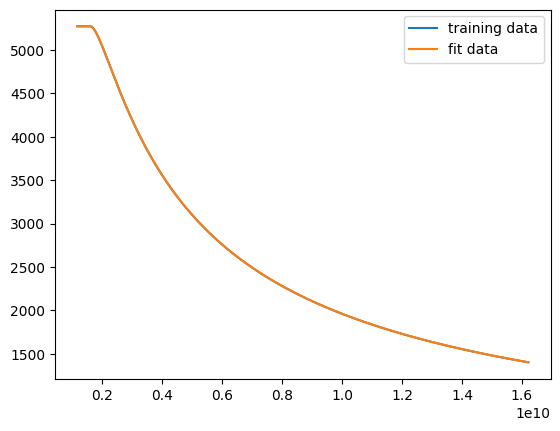

In [12]:
y_mod = fun2(res_lsq.x, r_train, 0)
plt.plot(r_train, temp_train,label='training data')
plt.plot(r_train, y_mod,label='fit data')
plt.legend()

Creating a function to store bt settl arrays in the form of a dictionary. Retrieval will be in the form of key calls.
Also this function should store the data and keep adding data for higher temperatures as it may be needed for later
iterations.
Test this and put into testing the visc disk flux generation

In [8]:
dr, t_max, d, r_in, r_sub = bf.generate_temp_arr(config=dict_config)
r_in, t_max

1011609956.3909127 m
1182690000.0 m


(<Quantity 1.18269e+09 m>, 53)

In [6]:
def generate_bts_dict(config, d: dict, t_max, dr, r_in=None):
    """Generate the flux contributed by the viscously heated disk
    Parameters
    ----------
    config : dict
        dictionary containing system parameters
    d : dict
        dictionary produced by generate_temp_arr, having the radii and their
        corresponding temperatures reduced to the integer values
    t_max : int
        maximum temperature of the viscously heated disk, reduced to nearest int BT-Settl value
    dr : astropy.units.Quantity or None
        thickness of each annulus
    r_in : astropy.units.Quantity
        inner truncation radius, needed to estimate padding

    Returns
    ----------
    wavelength : astropy.units.Quantity
        wavelength array in units of Angstrom
    obs_viscous_disk_flux : astropy.units.Quantity
        observed flux from the viscous disk, in units of erg / (cm^2 s A)
    """
    dict_wavelength = {}
    dict_flux = {}
    for int_temp in range(t_max, 13, -1):
        # to store total flux contribution from annuli of this temperature
        
        radii = np.array([r for r, t in d.items() if t == int_temp])
        radii = radii * u.m
        radii = sorted(radii, reverse=True)

        if int_temp in range(14, 20):  # constrained by availability of BT-Settl models
            logg = 3.5
        else:
            logg = 1.5

        wavelength, flux = bf.read_bt_settl(config, int_temp, logg, r_in)
        print(f"Temp\t:\t{int_temp}\tLogg\t:\t{logg}\tlen\t:\t{len(wavelength)}")
        dict_wavelength[f"{int_temp}"] = wavelength
        dict_flux[f"{int_temp}"] = flux
    # print(dict_wavelength)
    return dict_wavelength, dict_flux


        
        

In [9]:
dict_wave, dict_flux = generate_bts_dict(dict_config, d, t_max, dr, r_in)

Temp	:	53	Logg	:	1.5	len	:	350163
Temp	:	52	Logg	:	1.5	len	:	350154
Temp	:	51	Logg	:	1.5	len	:	350149
Temp	:	50	Logg	:	1.5	len	:	350155
Temp	:	49	Logg	:	1.5	len	:	350158
Temp	:	48	Logg	:	1.5	len	:	350165
Temp	:	47	Logg	:	1.5	len	:	350167
Temp	:	46	Logg	:	1.5	len	:	350169
Temp	:	45	Logg	:	1.5	len	:	350173
Temp	:	44	Logg	:	1.5	len	:	350178
Temp	:	43	Logg	:	1.5	len	:	350192
Temp	:	42	Logg	:	1.5	len	:	350194
Temp	:	41	Logg	:	1.5	len	:	350201
Temp	:	40	Logg	:	1.5	len	:	350217
Temp	:	39	Logg	:	1.5	len	:	350224
Temp	:	38	Logg	:	1.5	len	:	350230
Temp	:	37	Logg	:	1.5	len	:	350245
Temp	:	36	Logg	:	1.5	len	:	350261
Temp	:	35	Logg	:	1.5	len	:	350272
Temp	:	34	Logg	:	1.5	len	:	350299
Temp	:	33	Logg	:	1.5	len	:	350315
Temp	:	32	Logg	:	1.5	len	:	350344
Temp	:	31	Logg	:	1.5	len	:	350359
Temp	:	30	Logg	:	1.5	len	:	350385
Temp	:	29	Logg	:	1.5	len	:	350408
Temp	:	28	Logg	:	1.5	len	:	350426
Temp	:	27	Logg	:	1.5	len	:	350465
Temp	:	26	Logg	:	1.5	len	:	350521
Temp	:	25	Logg	:	1.5	len	:	420000
Temp	:	24	Logg

In [10]:
## Here defined a new function which takes the dictionaries of flux and wavelengths stored
# and does faster computation for viscous disk part
# it also add newer temperature data into the dict if not present earlier

def generate_visc_flux(config, dict_wave, dict_flux, d: dict, t_max, dr, r_in=None):
    """Generate the flux contributed by the viscously heated disk
    Parameters
    ----------
    config : dict
        dictionary containing system parameters
    d : dict
        dictionary produced by generate_temp_arr, having the radii and their
        corresponding temperatures reduced to the integer values
    t_max : int
        maximum temperature of the viscously heated disk, reduced to nearest int BT-Settl value
    dr : astropy.units.Quantity or None
        thickness of each annulus
    r_in : astropy.units.Quantity
        inner truncation radius, needed to estimate padding

    Returns
    ----------
    wavelength : astropy.units.Quantity
        wavelength array in units of Angstrom
    obs_viscous_disk_flux : astropy.units.Quantity
        observed flux from the viscous disk, in units of erg / (cm^2 s A)
    """
    
    plot = config['plot']
    save = config['save']
    save_each = config['save_each']
    save_loc = config['save_loc']
    d_star = config['d_star']
    inclination = config['inclination']
    m = config['m']
    l_min = config['l_min']
    l_max = config['l_max']
    n_data = config['n_data']
    viscous_disk_flux = np.zeros(n_data) * (u.erg * u.m ** 2 / (u.cm ** 2 * u.s * u.AA))  # total number of data points

    for int_temp in range(t_max, 13, -1):
        # to store total flux contribution from annuli of this temperature
        temp_flux = np.zeros(n_data) * (u.erg / (u.s * u.AA))

        radii = np.array([r for r, t in d.items() if t == int_temp])
        radii = radii * u.m
        radii = sorted(radii, reverse=True)

        if int_temp in range(14, 20):  # constrained by availability of BT-Settl models
            logg = 3.5
        else:
            logg = 1.5
        
        # wavelength, flux = read_bt_settl(config, int_temp, logg, r_in)  
        if f"{int_temp}" in dict_wave:
            wavelength = dict_wave[f"{int_temp}"]
            # wavelength = t_arr   # comes because it is the independent fitting axis
            flux = dict_flux[f"{int_temp}"]
        else:
            print("Data array doesn't exist in dict\nAdding it!")
            wavelength, flux = bf.read_bt_settl(config, int_temp, logg, r_in)
            print(f"Temp\t:\t{int_temp}\tLogg\t:\t{logg}")
            dict_wave[f"{int_temp}"] = wavelength
            dict_flux[f"{int_temp}"] = flux
        
        for r in radii:
            if inclination.value == 0:
                x_throw, y_final = bf.logspace_reinterp(config, wavelength, flux)
            else:
                v_kep = np.sqrt(const.G * m / r)
                v_red = v_kep * np.sin(inclination) / const.c
                interp_samp, wavelength_new, flux_new = bf.interpolate_conv(config, wavelength, flux, 100, v_red)
                kernel = bf.generate_kernel(config, interp_samp, v_red)

                convolved_spectra = np.convolve(flux_new, kernel, mode="same")

                x_throw, y_final = bf.logspace_reinterp(config, wavelength_new, convolved_spectra)
                if save_each:
                    np.save(f'{save_loc}/radius_{r}_flux.npy', y_final.value)
            temp_flux += y_final * np.pi * (2 * r * dr + dr ** 2)
        viscous_disk_flux += temp_flux
        print("completed for temperature of", int_temp, "\nnumber of rings included:", len(radii))
        if save:
            np.save(f'{save_loc}/{int_temp}_flux.npy', temp_flux.value)
    wavelength = np.logspace(np.log10(l_min.value), np.log10(l_max.value), n_data) * u.AA
    obs_viscous_disk_flux = viscous_disk_flux * np.cos(inclination) / (np.pi * d_star ** 2)
    obs_viscous_disk_flux = obs_viscous_disk_flux.to(u.erg / (u.cm ** 2 * u.s * u.AA))
    if save:
        np.save(f'{save_loc}/disk_component.npy', obs_viscous_disk_flux.value)
    if plot:
        plt.plot(wavelength, obs_viscous_disk_flux)
        plt.xlabel("Wavelength in Angstrom ----->")
        plt.ylabel("Flux [erg / ($cm^{2}$ s angstrom)] ----->")
        plt.title("Viscous Disk SED")
        plt.show()

    return wavelength, obs_viscous_disk_flux


In [11]:
wavelength, obs_viscous_disk_flux = generate_visc_flux(dict_config, dict_wave, dict_flux, d, t_max, dr)

/Users/tusharkantidas/anaconda3/envs/DS-env/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


completed for temperature of 53 
number of rings included: 16
completed for temperature of 52 
number of rings included: 5
completed for temperature of 51 
number of rings included: 4
completed for temperature of 50 
number of rings included: 3
completed for temperature of 49 
number of rings included: 3
completed for temperature of 48 
number of rings included: 4
completed for temperature of 47 
number of rings included: 3
completed for temperature of 46 
number of rings included: 3
completed for temperature of 45 
number of rings included: 4
completed for temperature of 44 
number of rings included: 4
completed for temperature of 43 
number of rings included: 3
completed for temperature of 42 
number of rings included: 4
completed for temperature of 41 
number of rings included: 4
completed for temperature of 40 
number of rings included: 5
completed for temperature of 39 
number of rings included: 4
completed for temperature of 38 
number of rings included: 5
completed for temperatu

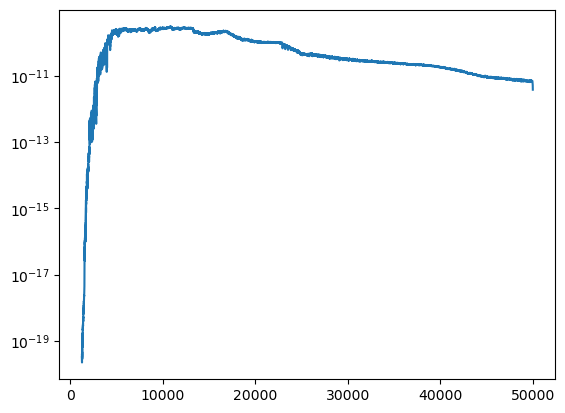

In [12]:
plt.plot(wavelength, obs_viscous_disk_flux)
plt.yscale('log')

In [23]:
def gen_visc_flux_lsq(t,config, dict_wave, dict_flux, d: dict, t_max, dr, r_in=None):
    """Generate the flux contributed by the viscously heated disk
    Parameters
    ----------
    config : dict
        dictionary containing system parameters
    d : dict
        dictionary produced by generate_temp_arr, having the radii and their
        corresponding temperatures reduced to the integer values
    t_max : int
        maximum temperature of the viscously heated disk, reduced to nearest int BT-Settl value
    dr : astropy.units.Quantity or None
        thickness of each annulus
    r_in : astropy.units.Quantity
        inner truncation radius, needed to estimate padding

    Returns
    ----------
    wavelength : astropy.units.Quantity
        wavelength array in units of Angstrom
    obs_viscous_disk_flux : astropy.units.Quantity
        observed flux from the viscous disk, in units of erg / (cm^2 s A)
    """
    plot = config['plot']
    save = config['save']
    save_each = config['save_each']
    save_loc = config['save_loc']
    d_star = config['d_star']
    inclination = config['inclination']
    m = config['m']
    l_min = config['l_min']
    l_max = config['l_max']
    n_data = config['n_data']
    viscous_disk_flux = np.zeros(n_data) * (u.erg * u.m ** 2 / (u.cm ** 2 * u.s * u.AA))  # total number of data points

    for int_temp in range(t_max, 13, -1):
        # to store total flux contribution from annuli of this temperature
        temp_flux = np.zeros(n_data) * (u.erg / (u.s * u.AA))

        radii = np.array([r for r, t in d.items() if t == int_temp])
        radii = radii * u.m
        radii = sorted(radii, reverse=True)

        if int_temp in range(14, 20):  # constrained by availability of BT-Settl models
            logg = 3.5
        else:
            logg = 1.5
        
        # wavelength, flux = read_bt_settl(config, int_temp, logg, r_in)
        if f"{int_temp}" in dict_wave:
            wavelength = dict_wave[f"{int_temp}"]
            # wavelength = t_arr   # comes because it is the independent fitting axis
            flux = dict_flux[f"{int_temp}"]
        else:
            # print("Data array doesn't exist in dict\nAdding it!")
            wavelength, flux = bf.read_bt_settl(config, int_temp, logg, r_in)
            print(f"Temp\t:\t{int_temp}\tLogg\t:\t{logg}")
            dict_wave[f"{int_temp}"] = wavelength
            dict_flux[f"{int_temp}"] = flux
        
        for r in radii:
            if inclination.value == 0:
                x_throw, y_final = bf.logspace_reinterp(config, wavelength, flux)
            else:
                v_kep = np.sqrt(const.G * m / r)
                v_red = v_kep * np.sin(inclination) / const.c
                interp_samp, wavelength_new, flux_new = bf.interpolate_conv(config, wavelength, flux, 100, v_red)
                kernel = bf.generate_kernel(config, interp_samp, v_red)

                convolved_spectra = np.convolve(flux_new, kernel, mode="same")

                x_throw, y_final = bf.logspace_reinterp(config, wavelength_new, convolved_spectra)
                if save_each:
                    np.save(f'{save_loc}/radius_{r}_flux.npy', y_final.value)
            temp_flux += y_final * np.pi * (2 * r * dr + dr ** 2)
        viscous_disk_flux += temp_flux
        print("completed for temperature of", int_temp, "\tnumber of rings included:", len(radii))
        if save:
            np.save(f'{save_loc}/{int_temp}_flux.npy', temp_flux.value)
    ## Here we have to fix the axis according to the input t
    # l_min = min(t)
    # l_max = max(t)
    # n_data = len(t)
    # print(l_min, l_max, n_data)
    wavelength = np.logspace(np.log10(l_min.value), np.log10(l_max.value), n_data) * u.AA
    obs_viscous_disk_flux = viscous_disk_flux * np.cos(inclination) / (np.pi * d_star ** 2)
    obs_viscous_disk_flux = obs_viscous_disk_flux.to(u.erg / (u.cm ** 2 * u.s * u.AA))
    if save:
        np.save(f'{save_loc}/disk_component.npy', obs_viscous_disk_flux.value)
    if plot:
        plt.plot(wavelength, obs_viscous_disk_flux)
        plt.xlabel("Wavelength in Angstrom ----->")
        plt.ylabel("Flux [erg / ($cm^{2}$ s angstrom)] ----->")
        plt.title("Viscous Disk SED")
        plt.show()

    return obs_viscous_disk_flux


In [57]:
dum_cfg = bf.config_read("config_file.cfg")

def fun_visc(x,t,y):
    """
    Error function for viscous disk flux fitting
    x[0] = m
    x[1] = m_dot
    x[2] = r_star
    x[3] = d_star
    x[4] = inclination
    x[5] = 
    Here the fitting is not so good because we are fixing the radius array, but in reality
    it also depends on the x vector parameters
    """
    print("**********************************")
    print(x)
    dum_cfg["m"] = x[0] * const.M_sun
    dum_cfg["m_dot"] = x[1] * const.M_sun/ (1 * u.year).to(u.s)
    # dum_cfg["r_star"] = x[3] * const.R_sun
    # dum_cfg["d_star"] = x[4]  * const.pc
    dum_cfg["inclination"] = x[2] * u.degree
    
    ## Below part is copeied from generate visc temp func with some changes
    dr, t_max, d, r_in, r_sub = bf.generate_temp_arr(dum_cfg)
    obs_viscous_disk_flux = gen_visc_flux_lsq(t,dum_cfg, dict_wave, dict_flux, d, t_max, dr)
    blank_list.append(obs_viscous_disk_flux.value)
    return (obs_viscous_disk_flux.value - y)/y

In [58]:
dum_cfg

{'b': <Quantity 1. kG>,
 'm': <Quantity 6.36291159e+30 kg>,
 'm_dot': <Quantity 2.52035626e+16 kg / s>,
 'r_star': <Quantity 1.18269e+09 m>,
 'log_g_star': 3.5,
 'inclination': <Quantity 38. deg>,
 'd_star': <Quantity 3.08567758e+17 m>,
 't_star': <Quantity 4600. K>,
 't_0': <Quantity 4600. K>,
 'av': 10.0,
 'rv': 3.1,
 'l_0': <Quantity 3000. Angstrom>,
 'l_l_slab': <Quantity 3000. Angstrom>,
 'mag_comp': 'hslab',
 't_slab': <Quantity 8500. K>,
 'n_e': <Quantity 1.e+13 1 / cm3>,
 'tau': 1.0,
 'save': True,
 'plot': False,
 'save_grid_data': False,
 'save_each': False,
 'l_min': <Quantity 1250. Angstrom>,
 'l_max': <Quantity 50000. Angstrom>,
 'n_data': 420000,
 'n_disk': 500,
 'n_dust_disk': 2000,
 'n_h_minus': 5000,
 'n_h': 150,
 'bt_settl_path': '/Users/tusharkantidas/NIUS/Temp',
 'save_loc': '/Users/tusharkantidas/NIUS/testing/Contribution/Planetesimal2',
 'h_grid_path': '/Users/tusharkantidas/NIUS/refactoring/grid/h_emission/Sample',
 'h_min_grid_path': '/Users/tusharkantidas/NIUS/

In [59]:
x0 = [1, 1e-6, 20]
blank_list = []
iter_num = 0  # it has been called inside fun_visc
res_lsq = least_squares(fun_visc, x0, args=(wavelength, obs_viscous_disk_flux.value),bounds = ((0.5,1e-7,18.),(4,2e-6,45.)))
res_lsq

**********************************
[1.e+00 1.e-06 2.e+01]
919348628.1519545 m
1182690000.0 m


/Users/tusharkantidas/anaconda3/envs/DS-env/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


completed for temperature of 50 	number of rings included: 16
completed for temperature of 49 	number of rings included: 7
completed for temperature of 48 	number of rings included: 4
completed for temperature of 47 	number of rings included: 4
completed for temperature of 46 	number of rings included: 4
completed for temperature of 45 	number of rings included: 3
completed for temperature of 44 	number of rings included: 4
completed for temperature of 43 	number of rings included: 4
completed for temperature of 42 	number of rings included: 4
completed for temperature of 41 	number of rings included: 5
completed for temperature of 40 	number of rings included: 4
completed for temperature of 39 	number of rings included: 5
completed for temperature of 38 	number of rings included: 5
completed for temperature of 37 	number of rings included: 5
completed for temperature of 36 	number of rings included: 5
completed for temperature of 35 	number of rings included: 6
completed for temperatu

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-8.529e-01 -8.524e-01 ...  6.171e-01  5.576e-01]
           x: [ 9.451e-01  1.274e-06  2.063e+01]
        cost: 18102.208681878044
         jac: [[ 6.765e-02  1.785e+05 -9.703e-04]
               [ 6.787e-02  1.792e+05 -9.677e-04]
               ...
               [-6.805e+00  1.095e+06 -1.030e+00]
               [-4.024e+00  1.030e+06 -8.686e-01]]
        grad: [ 3.062e+04  7.178e+09  3.934e+03]
  optimality: 13628.404395063284
 active_mask: [0 0 0]
        nfev: 7
        njev: 5

In [56]:
res_lsq.x

array([9.68106216e-01, 1.26293392e-06, 2.06343529e+01])

In [30]:
dum_cfg['m'] = res_lsq.x[0] * const.M_sun
dum_cfg['m_dot'] = res_lsq.x[1] * const.M_sun / (1*u.year).to(u.s)
dum_cfg['inclination'] = res_lsq.x[2] * u.degree

865228146.3849831 m
1182690000.0 m
completed for temperature of 52 	number of rings included: 18
completed for temperature of 51 	number of rings included: 5
completed for temperature of 50 	number of rings included: 3
completed for temperature of 49 	number of rings included: 4
completed for temperature of 48 	number of rings included: 3
completed for temperature of 47 	number of rings included: 4
completed for temperature of 46 	number of rings included: 3
completed for temperature of 45 	number of rings included: 4
completed for temperature of 44 	number of rings included: 3
completed for temperature of 43 	number of rings included: 4
completed for temperature of 42 	number of rings included: 4
completed for temperature of 41 	number of rings included: 4
completed for temperature of 40 	number of rings included: 5
completed for temperature of 39 	number of rings included: 4
completed for temperature of 38 	number of rings included: 5
completed for temperature of 37 	number of rings 

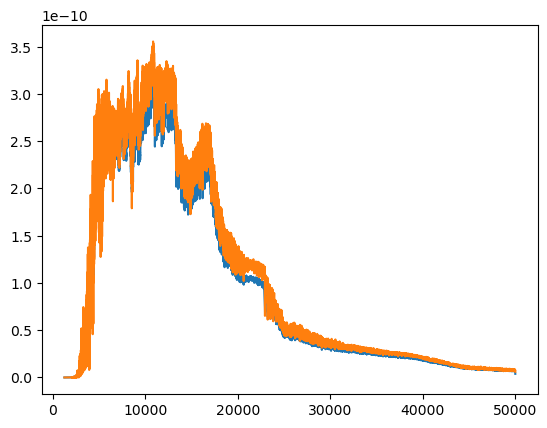

In [28]:
dr, t_max, d, r_in, r_sub = bf.generate_temp_arr(config=dum_cfg)
y_mod_visc = gen_visc_flux_lsq(0.,dum_cfg, dict_wave, dict_flux, d, t_max, dr)
plt.plot(wavelength, obs_viscous_disk_flux)
plt.plot(wavelength, y_mod_visc)

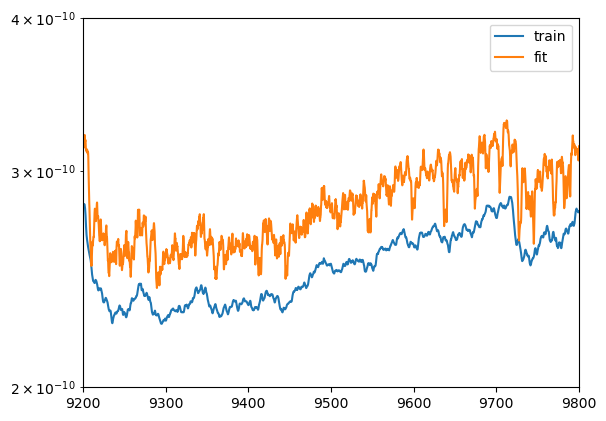

In [36]:
plt.plot(wavelength, obs_viscous_disk_flux,label='train')
plt.plot(wavelength, y_mod_visc, label = 'fit')
plt.xlim(9200,9800)
plt.ylim(2e-10,4e-10)
plt.legend()
plt.yscale('log')

In [29]:
dum_cfg

{'b': <Quantity 1. kG>,
 'm': <Quantity 1.17939018e+30 kg>,
 'm_dot': <Quantity 2.80117195e+16 kg / s>,
 'r_star': <Quantity 1.18269e+09 m>,
 'log_g_star': 3.5,
 'inclination': <Quantity 39.32915341 deg>,
 'd_star': <Quantity 3.08567758e+17 m>,
 't_star': <Quantity 4600. K>,
 't_0': <Quantity 4600. K>,
 'av': 10.0,
 'rv': 3.1,
 'l_0': <Quantity 3000. Angstrom>,
 'l_l_slab': <Quantity 3000. Angstrom>,
 'mag_comp': 'hslab',
 't_slab': <Quantity 8500. K>,
 'n_e': <Quantity 1.e+13 1 / cm3>,
 'tau': 1.0,
 'save': False,
 'plot': False,
 'save_grid_data': False,
 'save_each': False,
 'l_min': <Quantity 1250. Angstrom>,
 'l_max': <Quantity 50000. Angstrom>,
 'n_data': 420000,
 'n_disk': 500,
 'n_dust_disk': 2000,
 'n_h_minus': 5000,
 'n_h': 150,
 'bt_settl_path': '/home/arch/yso/trial_downloads',
 'save_loc': '/home/arch/yso/trial_25_03/save',
 'h_grid_path': '/home/arch/yso/H_slab_data/GridHslab',
 'h_min_grid_path': '/home/arch/yso/H_slab_data/GridH-slab'}

In [46]:
dict_config

{'b': <Quantity 1. kG>,
 'm': <Quantity 1.98840987e+30 kg>,
 'm_dot': <Quantity 2.52035626e+16 kg / s>,
 'r_star': <Quantity 1.18269e+09 m>,
 'log_g_star': 3.5,
 'inclination': <Quantity 38. deg>,
 'd_star': <Quantity 3.08567758e+17 m>,
 't_star': <Quantity 4600. K>,
 't_0': <Quantity 4600. K>,
 'av': 10.0,
 'rv': 3.1,
 'l_0': <Quantity 3000. Angstrom>,
 'l_l_slab': <Quantity 3000. Angstrom>,
 'mag_comp': 'hslab',
 't_slab': <Quantity 8500. K>,
 'n_e': <Quantity 1.e+13 1 / cm3>,
 'tau': 1.0,
 'save': False,
 'plot': False,
 'save_grid_data': False,
 'save_each': False,
 'l_min': <Quantity 1250. Angstrom>,
 'l_max': <Quantity 50000. Angstrom>,
 'n_data': 420000,
 'n_disk': 500,
 'n_dust_disk': 2000,
 'n_h_minus': 5000,
 'n_h': 150,
 'bt_settl_path': '/home/arch/yso/trial_downloads',
 'save_loc': '/home/arch/yso/trial_25_03/save',
 'h_grid_path': '/home/arch/yso/H_slab_data/GridHslab',
 'h_min_grid_path': '/home/arch/yso/H_slab_data/GridH-slab'}

In [76]:
d

{1194475861.3142483: 39,
 1216607167.276387: 39,
 1238738473.2385254: 39,
 1260869779.200664: 39,
 1283001085.1628027: 39,
 1305132391.124941: 39,
 1327263697.0870798: 39,
 1349395003.0492182: 39,
 1371526309.0113568: 39,
 1393657614.9734955: 39,
 1415788920.935634: 39,
 1437920226.8977726: 39,
 1460051532.859911: 39,
 1482182838.8220496: 39,
 1504314144.7841883: 39,
 1526445450.746327: 39,
 1548576756.7084653: 39,
 1570708062.6706038: 39,
 1592839368.6327424: 39,
 1614970674.594881: 39,
 1637101980.5570197: 39,
 1659233286.5191581: 39,
 1681364592.4812968: 39,
 1703495898.4434352: 39,
 1725627204.4055738: 39,
 1747758510.3677125: 39,
 1769889816.329851: 39,
 1792021122.2919896: 39,
 1814152428.254128: 39,
 1836283734.2162666: 39,
 1858415040.1784053: 38,
 1880546346.140544: 38,
 1902677652.1026824: 38,
 1924808958.0648208: 38,
 1946940264.0269594: 38,
 1969071569.989098: 38,
 1991202875.9512367: 38,
 2013334181.9133751: 38,
 2035465487.8755138: 37,
 2057596793.8376522: 37,
 2079728099

In [61]:
blank_list = np.array(blank_list)

In [65]:
np.save("Least_sq_files/obs_fits.npy", blank_list)

In [70]:
np.save("obs_viscous_disk_flux.npy", obs_viscous_disk_flux.value)